# Di-Higgs momentum regressor final training

## Import

### Import modules

In [3]:
import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
import time
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GaussianNoise, BatchNormalization, Merge
from keras.layers.advanced_activations import ELU, PReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras import backend as K
from __future__ import division 
import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
from sklearn.pipeline import Pipeline
import json
import glob
import pickle
from sklearn.externals import joblib
import seaborn as sns
import sys
sys.path.append('../../../../modules')
from MPPlot import *
from Processors import *
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
sys.path.append('../')
from Regression_Application import *


### Import data
Here just looking at mu tau_h b b final-state

In [4]:
mode = "mu_tau_b_b"
loc = '../../../../../../data_n/'
SignalData = []
BackgroundData = []

energies = [260, 270, 280, 300, 320, 400, 500, 550, 600 ,700]
backgrounds = ['TT' , 'WJetsToLNu']
Data = np.concatenate((energies,backgrounds))



 #Load data from CSV files
for energy in energies:
    signaldata = pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + str(energy) +"_narrow_13TeV-madgraph.csv")
    signaldata['mass'] = energy
    SignalData.append(signaldata)


for back in backgrounds:
    backgroundData = pandas.read_csv(loc + back + "_TuneCUETP8M1_13TeV.csv")
    backgroundData['mass'] = 0
    BackgroundData.append(backgroundData)    
     
    
signalData = SignalData[0]
for signal_data in SignalData[1:]:
    signalData = signalData.append(signal_data, ignore_index=True)    
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)    
signalData['gen_target'] = pandas.Series(np.ones(signalData.size))
backgroundData = BackgroundData[0]
for background_data in BackgroundData[1:]:
    backgroundData = backgroundData.append(background_data, ignore_index=True)    
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)    
backgroundData['gen_target'] = pandas.Series(np.zeros(backgroundData.size))

print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset
def cleanData(X):
    """
    Recives data and labels (X and y)
    
    Returns: X, y after removing points that would fail to convert to float32 
    """
    
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    
    X = X[np.logical_not(selecting)].reset_index(drop=True)#.values.astype('float32')
    
    return X


data = cleanData(data)


Samples contains 10417 signal events and 168053 background events
178470 events in total


## Configure data

### Create development and validation samples

In [5]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH', 'gen_t_0', 'gen_t_1', 'gen_b_0' ,'gen_b_1', 'gen_diH']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    if(not str.startswith(p, "gen")):
        addEnergy(data, p) #Calculate energy and absolute momentum
 

moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))



In [6]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)

    
devData = data.loc[sig_devIndeces].copy()
#devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData)))


3928 events for training, 174533 events for validation


### Apply regressors

In [7]:
bRegressor = BPairRegressor(data, "../bRegression/weights/NN_B_Regressor_App_" + mode + "_"  , mode)
bRegressor.evalResponse()
bRegressor.getExtraVariables()
bRegressor.refineDiHiggsVector()

10 components found in ensemble


In [8]:
tauRegressor = TauPairRegressor(data, "../tauRegression/weights/NN_Tau_Regressor_App_" + mode + "_"  , mode)
tauRegressor.evalResponse()
tauRegressor.getExtraVariables()
tauRegressor.refineDiHiggsVector()

10 components found in ensemble


### Specify variables

In [23]:

genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]

In [24]:
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi', 't_1_mass'] if x in var]
other = [var for var in trainFeatures for x in ['Fit','csv'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi + other]

In [25]:
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_"))]
regFeatures = [var for var in trainFeatures if (str.startswith(var, "reg"))]
regBFeatures = [var for var in trainFeatures if (str.startswith(var, "regB_"))]
regTauFeatures = [var for var in trainFeatures if (str.startswith(var, "regTau_"))]
regBDiHiggs = [var for var in regBFeatures if (str.startswith(var, "regB_diH_"))]
regTauDiHiggs = [var for var in regTauFeatures if (str.startswith(var, "regTau_diH_"))]
diHiggsFeatures = [var for var in trainFeatures if (str.startswith(var, "diH_"))]
regBasis = [var[var.find("_")+1:] for var in regFeatures]
massFeatures = [var for var in trainFeatures if "_mass" in var]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in  shapeFeatures + pTEtaPhi + hlFeatures + recoFeatures]
reducedFSFeatures = [var for var in fsFeatures if var not in regBasis]
reducedRecoFeatures = [var for var in recoFeatures if var not in regBasis]

In [26]:
set0 = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi + regBFeatures + regTauFeatures] + ['hl_mT']
set1 = [var for var in reducedFSFeatures + reducedRecoFeatures if var not in pTEtaPhi + regBDiHiggs] + ['hl_mT']

## Specify options

In [27]:
regTrainFeatures = set1
regModel = 'model0'
normIn = True
normOut = True
pca = True
whiten = False
nSplits = 10
cvTests = True
ensembleSize = 10
ensembleMode = 'loss'
regTargetFeatures = ['gen_diH_px', 'gen_diH_py', 'gen_diH_pz']
print "\nTraining on", len(regTrainFeatures), "features:", [var for var in regTrainFeatures]
print "\nRegressing to", len(regTargetFeatures), "features:", [var for var in regTargetFeatures]


Training on 52 features: ['t_0_mass', 'b_0_mass', 'b_1_mass', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'mass', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_0_|p|', 'regB_b_0_E', 'regB_b_1_|p|', 'regB_b_1_E', 'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regB_h_bb_E', 'regB_h_bb_|p|', 'regB_h_bb_mass', 'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_0_|p|', 'regTau_t_0_E', 'regTau_t_1_|p|', 'regTau_t_1_E', 'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regTau_h_tt_E', 'regTau_h_tt_|p|', 'regTau_h_tt_mass', 'regTau_diH_px', 'regTau_diH_py', 'regTau_diH_pz', 'regTau_diH_E', 'regTau_diH_|p|', 'regTau_diH_mass', 'hl_mT']

Regressing to 3 features: ['gen_diH_px', 'gen_diH_py', 'gen_diH_pz']


In [28]:
devData = data.loc[sig_devIndeces].copy()
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)
print "{0} events for training, {1} events for validation".format(len(devData), len(valData))

3928 events for training, 174533 events for validation


## Define regressor

In [29]:
def getLayout(params):
    architecture = int(params[0])
    nodes = int(params[1])
    depth = int(params[2])
    layout = np.zeros(depth).astype(int)
    if architecture == 0: #Box: same number of nodes in each layer
        layout.fill(nodes)
    if architecture == 1: #Taper: linear reduction of width with depth
        coef = (len(regTargetFeatures)-nodes)/(depth+1)
        for l in range(depth):
            layout[l] = nodes+(coef*l)
    if architecture == 2: #Choke: linear reduction down to Noutputs at centre layer
        centre = int(math.ceil(depth/2))
        coefRed = (len(regTargetFeatures)-nodes)/(centre)
        coefInc = (nodes-len(regTargetFeatures))/(depth-centre)
        mod = -1
        if (depth % 2 == 0) and (depth != 2):
            mod = 1
        for l in range(centre+mod):
            layout[l] = nodes+(coefRed*l)
        for l in range(centre+mod, depth):
            layout[l] = len(regTargetFeatures)+(coefInc*(l-centre+1))
    if architecture == 3: #Funnel: linearly reduces to Noutputs at centre layer then moves to box layput
        centre = int(math.ceil(depth/2))
        coefRed = (len(regTargetFeatures)-nodes)/(centre)
        mod = -1
        if (depth % 2 == 0) and (depth != 2):
            mod = 1
        for l in range(centre+mod):
            layout[l] = nodes+(coefRed*l)
        for l in range(centre+mod, depth):
            layout[l] = len(regTargetFeatures)
    return layout

In [30]:
def getParameterisedRegressor(params):
    params = params.tolist()
    noise = params[0]
    dropout = params[1]
    layers = getLayout(params[2:])
    regModel = Sequential()
    regModel.add(Dense(int(layers[0]), input_dim=len(regTrainFeatures), init='glorot_normal'))
    regModel.add(PReLU())
    regModel.add(GaussianNoise(noise))
    regModel.add(BatchNormalization())
    regModel.add(Dropout(dropout))
    for i in layers[1:]:
        if i < len(regTargetFeatures): break
        regModel.add(Dense(int(i), init='glorot_normal'))
        regModel.add(PReLU())
        regModel.add(GaussianNoise(noise))
        regModel.add(BatchNormalization())
        regModel.add(Dropout(dropout))
    regModel.add(Dense(len(regTargetFeatures), activation='linear', init='glorot_normal'))
    regModel.compile(loss='mse', optimizer='nadam')
    modelVersion = "model0"
    return regModel

In [31]:
compileArgs = {'loss' : 'mse', 'optimizer' : 'nadam'}

def getRegressor(model):
    regModel = Sequential()
    if model == "model0":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal', activation='selu'))
        regModel.add(Dense(100, kernel_initializer='he_normal', activation='selu'))
        regModel.add(Dense(100, kernel_initializer='he_normal', activation='selu'))
        regModel.add(Dense(100, kernel_initializer='he_normal', activation='selu'))
        regModel.add(Dense(100, kernel_initializer='he_normal', activation='selu'))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model1":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model2":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model3":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(BatchNormalization())
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(BatchNormalization())
        regModel.add(PReLU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(BatchNormalization())
        regModel.add(PReLU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model4":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_uniform'))
    elif model == "model5":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model6":
        regModel.add(Dense(150, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(120, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal')) 
    elif model == "model7":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='glorot_normal', activation='linear'))
        regModel.add(Dense(100, kernel_initializer='glorot_normal', activation='linear'))
        regModel.add(Dense(100, kernel_initializer='glorot_normal', activation='linear'))
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model8":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(PReLU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model9":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    elif model == "model10":
        regModel.add(Dense(100, input_dim=len(regTrainFeatures), kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(100, kernel_initializer='he_normal'))
        regModel.add(ELU())
        regModel.add(BatchNormalization())
        regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='glorot_normal'))
    regModel.compile(**compileArgs)
    return regModel

## Evaluation

### Preprocess data

In [32]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
inputPipe = Pipeline(stepsIn)
stepsOut = []
if normOut:
    stepsOut.append(('normOut', StandardScaler()))
else:
    stepsOut.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
outputPipe = Pipeline(stepsOut)

In [33]:
X_reg = inputPipe.fit_transform(devData[regTrainFeatures].values.astype(theano.config.floatX))
y_reg = outputPipe.fit_transform(devData[regTargetFeatures].values.astype(theano.config.floatX))

### Train regressors
Train nSplit times to find best convergence

In [34]:
trainingData = (None, None)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(trainingData[0], trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))

In [35]:
trainParams = {'epochs' : 10000, 'batch_size' : 64, 'verbose' : 0}

In [36]:
start = time.time()
results = []
histories = []
os.system("rm train_weights/*.h5")
os.system("rm train_weights/*.json")
os.system("rm train_weights/*.pkl")
if cvTests:
    kf = KFold(n_splits=nSplits, shuffle=True)
    i = 0
    for train, test in kf.split(X_reg):
        i += 1
        print "Running fold", i, "/", nSplits
        model = None # Clearing the NN
        model = getRegressor(regModel)
        model.reset_states #Just checking
        trainingData = (X_reg[train], y_reg[train])
        lossHistory = LossHistory()
        earlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
        saveBest = ModelCheckpoint("train_weights/best.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
        model.fit(X_reg[train], y_reg[train],
                  validation_data = (X_reg[test], y_reg[test]),
                  callbacks = [earlyStop, saveBest, lossHistory],
                  **trainParams)
        histories.append(lossHistory.losses)
        model.load_weights("train_weights/best.h5")
        results.append({})
        results[-1]['loss'] = model.evaluate(X_reg[test], y_reg[test], verbose=0)
        print "Score is:", results[-1]
        model.save('train_weights/train_' + str(i-1) + '.h5')
else :
    for i in range(nSplits):
        print "Running fold", i+1, "/", nSplits
        model = None # Clearing the NN.
        model = getRegressor(regModel)
        model.reset_states #Just checking
        earlyStop = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
        saveBest = ModelCheckpoint("train_weights/best.h5", monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
        histories.append(model.fit(X_reg, y_reg,
                  callbacks = [earlyStop, saveBest],
                  **trainParams))
        model.load_weights("train_weights/best.h5")
        results.append({})
        results[-1]['loss'] = model.evaluate(X_reg, y_reg, verbose=0)
        print "Score is:", results[-1]
        model.save('train_weights/train_' + str(i) + '.h5')
with open('train_weights/resultsFile.pkl', 'w') as fout:
    pickle.dump(results, fout)
print "Cross-validation took {:.3f}s ".format(time.time() - start)
X_reg = None
y_reg = None
train = None
test = None
model.summary()
model = None

Running fold 1 / 10
Epoch 00034: early stopping
Score is: {'loss': 0.064380978032681169}
Running fold 2 / 10
Epoch 00035: early stopping
Score is: {'loss': 0.061783472090277056}
Running fold 3 / 10
Epoch 00050: early stopping
Score is: {'loss': 0.064170905708811662}
Running fold 4 / 10
Epoch 00099: early stopping
Score is: {'loss': 0.036107879236302605}
Running fold 5 / 10
Epoch 00070: early stopping
Score is: {'loss': 0.052898746704251411}
Running fold 6 / 10
Epoch 00063: early stopping
Score is: {'loss': 0.04629285506543919}
Running fold 7 / 10
Epoch 00109: early stopping
Score is: {'loss': 0.041126225759813194}
Running fold 8 / 10
Epoch 00105: early stopping
Score is: {'loss': 0.051925695446763023}
Running fold 9 / 10
Epoch 00070: early stopping
Score is: {'loss': 0.047669401354327491}
Running fold 10 / 10
Epoch 00096: early stopping
Score is: {'loss': 0.045505899403776438}
Cross-validation took 361.305s 
_________________________________________________________________
Layer (type)

### Plot training histories

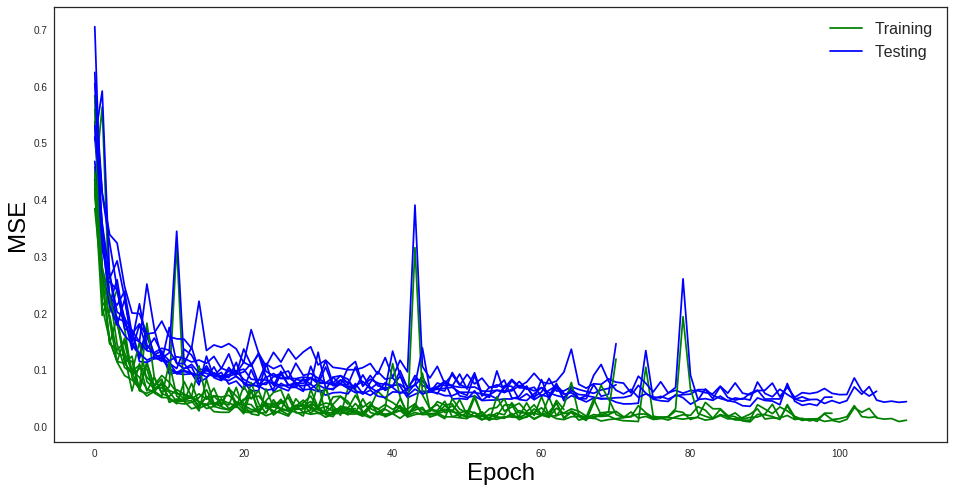

In [37]:
plt.figure(figsize=(16,8))
if cvTests:
    for i, history in enumerate(histories):
        if i == 0:
            plt.plot(history['loss'], color='g', label='Training')
            plt.plot(history['val_loss'], color='b', label='Testing')
        else:
            plt.plot(history['loss'], color='g')
            plt.plot(history['val_loss'], color='b')
    plt.legend(fontsize=16)
else:
    for history in histories:
        plt.plot(history.history['loss'])
plt.xlabel("Epoch", fontsize=24, color='black')
plt.ylabel("MSE", fontsize=24, color='black')

## Construct ensemble

In [38]:
results = None
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [39]:
def loadModel(cycle, location='train_weights/train_'):
    cycle = int(cycle)
    model = load_model(location + str(cycle) + '.h5')
    model.compile(**compileArgs)
    return model

In [40]:
def getWeights(value, met):
    return 1/value

In [41]:
ensemble = []
weights = []
print "Choosing ensemble by", ensembleMode
if ensembleMode == 'mix':
    for met in results[0]:
        print "Choosing best for metric", met
        cycle = np.argmin([result[met] for result in results])
        print met, "Model", "is", cycle, "with", met, "=", results[cycle][met]
        ensemble.append(loadModel(cycle))
        weights.append(1)
else:
    dtype = [('cycle', int), ('result', float)]
    values = np.sort(np.array([(i, result[ensembleMode]) for i, result in enumerate(results)], dtype=dtype),
                     order=['result'])
    for i in range(min([ensembleSize, len(results)])):
        ensemble.append(loadModel(values[i]['cycle']))
        weights.append(getWeights(values[i]['result'], ensembleMode))
        print "Model", i, "is", values[i]['cycle'], "with", ensembleMode, "=", values[i]['result']
weights = np.array(weights)
weights = weights/weights.sum() #normalise weights

Choosing ensemble by loss
Model 0 is 3 with loss = 0.0361078792363
Model 1 is 6 with loss = 0.0411262257598
Model 2 is 9 with loss = 0.0455058994038
Model 3 is 5 with loss = 0.0462928550654
Model 4 is 8 with loss = 0.0476694013543
Model 5 is 7 with loss = 0.0519256954468
Model 6 is 4 with loss = 0.0528987467043
Model 7 is 1 with loss = 0.0617834720903
Model 8 is 2 with loss = 0.0641709057088
Model 9 is 0 with loss = 0.0643809780327


## Save/load

In [42]:
name = "weights/NN_HH_Mom_Regressor_App_" + mode + "_" 
print name

weights/NN_HH_Mom_Regressor_App_mu_tau_b_b_


### Save

In [43]:
os.system("rm " + name + "*.json")
os.system("rm " + name + "*.h5")
os.system("rm " + name + "*.pkl")
for i, model in enumerate(ensemble):
    json_string = model.to_json()
    open(name + '_' + str(i) + '.json', 'w').write(json_string)
    model.save_weights(name + '_' + str(i) + '.h5')
with open(name + '_compile.json', 'w') as fout:
    json.dump(compileArgs, fout)
with open(name + '_weights.pkl', 'w') as fout:
    pickle.dump(weights, fout)
with open(name + '_inputPipe.pkl', 'w') as fout:
    pickle.dump(inputPipe, fout)
with open(name + '_outputPipe.pkl', 'w') as fout:
    pickle.dump(outputPipe, fout)

## Response of ensemble on development data

###  Preprocess data

In [44]:
X_dev = inputPipe.transform(devData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [45]:
pred = np.zeros((len(devData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_dev, verbose=0)) 
for n, feature in enumerate(regTargetFeatures):
    devData['regHH_' + feature[4:]] = pandas.Series(pred[:,n], index=devData.index)

### Evaluate response

In [46]:
devData['loss_d'] = 0
for n, feature in enumerate(regTargetFeatures):
    devData.ix[:, 'loss_d'] += np.square(devData.ix[:, 'regHH_' + feature[4:]]-devData.ix[:, feature])
print 'Ensemble on dev data:\n Loss = {}'.format(np.mean(devData.ix[:, 'loss_d'])/len(regTargetFeatures))

/home/goncalo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#depr

Ensemble on dev data:
 Loss = 264.689894414


## Response of ensemble on validation data

###  Preprocess data

In [ ]:
X_val = inputPipe.transform(valData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [ ]:
pred = np.zeros((len(valData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_val, verbose=0)) 
for n, feature in enumerate(regTargetFeatures):
    valData['regHH_' + feature[4:]] = pandas.Series(pred[:,n], index=valData.index)

### Evaluate response

In [ ]:
valData['loss_v'] = 0
for n, feature in enumerate(regTargetFeatures):
    valData.ix[sig, 'loss_v'] += np.square(valData.ix[sig, 'regHH_' + feature[4:]]-valData.ix[sig, feature])
print 'Ensemble on val data:\n Loss = {}'.format(np.mean(valData.ix[sig, 'loss_v'])/len(regTargetFeatures))

### Two-sample Kolmogorov–Smirnov test

In [ ]:
for n, feature in enumerate(regTargetFeatures):
    print 
    print feature
    ksTest = ks_2samp(valData[sig][feature].values, valData[sig]['regHH_' + feature[4:]].values)
    print "K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1])

### Di-Higgs momenta distribution

In [ ]:
pltArgs = []
for n, feature in enumerate(regTargetFeatures):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sig, feature], 'x':xPlot, 'name':'gen_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sig, feature[4:]], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sig, 'regHH_' + feature[4:]], 'x':xPlot, 'name':'reg_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)

In [ ]:
for n, feature in enumerate(regTargetFeatures):
    xPlot =  np.linspace(-600, 600, 500)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-1500, 1500, 500)[:, np.newaxis]
    var = "p_{x,hh}"
    if "py" in feature:
        var = "p_{y,hh}"
    if "pz" in feature:
        var = "p_{z,hh}"
    if "_1_" in feature:
        var = var[:-1] + "1"
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data=valData.ix[sig, feature])
    sns.kdeplot(data=valData.ix[sig, feature[4:]])
    sns.kdeplot(data=valData.ix[sig, 'regHH_' + feature[4:]])
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### Momentum pull distributions

In [ ]:
pltArgs = []
for n, feature in enumerate(regTargetFeatures):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    pltArgs += [{'data':valData.ix[sig, feature[4:]]-valData.ix[sig, feature], 'x':xPlot, 'name':'rec_' + feature, 'kde':1, 'mean':1, 'std':1},
                {'data':valData.ix[sig, 'regHH_' + feature[4:]]-valData.ix[sig, feature], 'x':xPlot, 'name':'reg_' + feature, 'kde':1, 'mean':1, 'std':1}]
plots = mpRun(pltArgs)

In [ ]:
for n, feature in enumerate(regTargetFeatures):
    xPlot =  np.linspace(-100, 100, 400)[:, np.newaxis]
    if 'pz' in feature:
        xPlot = np.linspace(-150, 150, 600)[:, np.newaxis]
    var = "p_{x,hh"
    if "py" in feature:
        var = "p_{y,hh"
    if "pz" in feature:
        var = "p_{z,hh"
    if "_1_" in feature:
        var = var[:-1] + "1"
    plt.figure(figsize=(8, 6))
    mean = (np.mean(plots['rec_' + feature + '_mean']),
            np.std(plots['rec_' + feature + '_mean'])/math.sqrt(len(plots['rec_' + feature + '_mean'])))
    stdev = (np.mean(plots['rec_' + feature + '_std']),
             np.std(plots['rec_' + feature + '_std'])/math.sqrt(len(plots['rec_' + feature + '_std'])))
    print "Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.kdeplot(data=valData.ix[sig, feature[4:]]-valData.ix[sig, feature])
    mean = (np.mean(plots['reg_' + feature + '_mean']),
            np.std(plots['reg_' + feature + '_mean'])/math.sqrt(len(plots['reg_' + feature + '_mean'])))
    stdev = (np.mean(plots['reg_' + feature + '_std']),
             np.std(plots['reg_' + feature + '_std'])/math.sqrt(len(plots['reg_' + feature + '_std'])))
    print "Reg:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1])
    sns.kdeplot(data=valData.ix[sig, 'regHH_' + feature[4:]]-valData.ix[sig, feature])
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

## Save/load

In [ ]:
name = "weights/NN_HH_Mom_Regressor_App_" + mode + "_" 
print name

### Save

In [ ]:
os.system("rm " + name + "*.json")
os.system("rm " + name + "*.h5")
os.system("rm " + name + "*.pkl")
for i, model in enumerate(ensemble):
    json_string = model.to_json()
    open(name + '_' + str(i) + '.json', 'w').write(json_string)
    model.save_weights(name + '_' + str(i) + '.h5')
with open(name + '_compile.json', 'w') as fout:
    json.dump(compileArgs, fout)
with open(name + '_weights.pkl', 'w') as fout:
    pickle.dump(weights, fout)
with open(name + '_inputPipe.pkl', 'w') as fout:
    pickle.dump(inputPipe, fout)
with open(name + '_outputPipe.pkl', 'w') as fout:
    pickle.dump(outputPipe, fout)

### Load

In [ ]:
ensemble = []
weights = None
inputPipe = None
outputPipe = None
compileArgs = None
with open(name + '_compile.json', 'r') as fin:
    compileArgs = json.load(fin)
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name + "_" + str(i) + '.h5')
    model.compile(**compileArgs)
    ensemble.append(model)
with open(name + '_weights.pkl', 'r') as fin:
    weights = pickle.load(fin)
with open(name + '_inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)
with open(name + '_outputPipe.pkl', 'r') as fin:
    outputPipe = pickle.load(fin)